In [1]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn import metrics
from sklearn.metrics import roc_auc_score

# import matplotlib.pyplot as plt

from sklearn.externals import joblib

In [2]:
import pickle

In [3]:
import matplotlib.pyplot as plt

In [4]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [5]:
from sklearn.metrics import accuracy_score

In [6]:
import pandas as pd
import numpy as np

In [7]:
import time

### Model trainig with hyper-parameter tuning

In [8]:
## Model developed to be used in for loop without print statement

def model_fit_hyperopt(params):
    
#     attempt_count += 1
    
    global num
    f1 = open("status.txt", "w")
    f1.write("num:{}".format(num))
    f1.close() 
    num = num +1

    ### Asssigning default parameters
#     useTrainCV = False
    cv_folds = 5
    early_stopping_rounds = 50
    
    ### Forming copy of input datasets
    train_c, valid_c, test_c = train_sample.copy(), valid_sample.copy(), test.copy()
#     out_path = params['out_path']
    predictors, target = list(params['predictors']), params['target']
    
    alg = XGBClassifier(
                learning_rate =params['learning_rate'],
                n_estimators=10,
                max_depth=params['max_depth'],
                min_child_weight=params['min_child_weight'],
                gamma=params['gamma'],
                subsample=params['subsample'],
                colsample_bytree=params['colsample_bytree'],
                objective= 'binary:logistic',
                scale_pos_weight=params['scale_pos_weight'],
                seed=27, n_jobs=6)

#     if useTrainCV:
#         xgb_param = alg.get_xgb_params()
#         xgtrain = xgb.DMatrix(train_c[predictors].values, label=train_c[target].values)
#         xgtest = xgb.DMatrix(valid_c[predictors].values)
#         cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
#             metrics = 'auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False, seed=27)
#         ne_new = n_estimators=cvresult.shape[0]
#         alg.set_params(n_estimators=cvresult.shape[0])
        
    #Fit the algorithm on the data
    eval_set = [(valid_c[predictors],valid_c[target])]
    alg.fit(train_c[predictors], train_c[target],eval_metric='auc', early_stopping_rounds=early_stopping_rounds, eval_set = eval_set, verbose = True)     
    
    valid_c.loc[:,'prob'] = alg.predict_proba(valid_c[predictors])[:,1]
    test_c.loc[:,'prob'] = alg.predict_proba(test_c[predictors])[:,1]
    
    valid_auc = roc_auc_score(np.array(valid_c.loc[:,target]), np.array(valid_c.loc[:,'prob']))
    test_auc = roc_auc_score(np.array(test_c.loc[:,target]), np.array(test_c.loc[:,'prob']))
    loss = 1 - valid_auc
    del train_c
    del valid_c
    del test_c
#     if out_path != None:
#         f = open(os.path.join(out_path, "hyperopt_logs.txt"), "a+")
#         f.write("Valid AUC: {} and Test AUC: {}, loss: {}".format(valid_auc,test_auc,loss))
#         f.close()
    
    print ("Valid AUC: {} and Test AUC: {}, Loss: {}".format(valid_auc, test_auc, loss))
    
    return {'loss': loss, 'status': STATUS_OK, 'params': params, 'model':alg}

In [9]:
def get_best_model_xgb(space, train, valid, test):
    
#     f = open(os.path.join(out_path, "hyperopt_logs.txt"), "w+")
#     f.close()

    
    trials=Trials()
    global num
    num = 1
    best = fmin(model_fit_hyperopt, space, algo=tpe.suggest, max_evals=50, trials=trials)
    
    return trials.best_trial['result']['model'], trials.best_trial['result']

In [10]:
# def train_validate_test_split(df, train_percent=.60, validate_percent=.20, seed=42):
#     np.random.seed(seed)
#     perm = np.random.permutation(df.index)
#     m = len(df.index)
#     train_end = int(train_percent * m)
#     validate_end = int(validate_percent * m) + train_end
#     train = df.iloc[perm[:train_end]]
#     validate = df.iloc[perm[train_end:validate_end]]
#     test = df.iloc[perm[validate_end:]]
#     return train, validate, test

In [11]:
def data(df,target):
    processed_df = pd.get_dummies(df,sparse=True)
    df_features = list(set(processed_df.columns) - set([target]))
#     train, valid, test = train_validate_test_split(processed_df)
    train = processed_df.ix[train_o.index]
    valid = processed_df.ix[valid_o.index]
    test = processed_df.ix[test_o.index]
    return train, valid, test, df_features, target

In [23]:
train_o = pd.read_csv('../../data/train_insurance.csv',index_col = 0)
valid_o = pd.read_csv('../../data/valid_insurance.csv',index_col = 0)
test_o = pd.read_csv('../../data/test_insurance.csv',index_col = 0)

In [24]:
all_data = pd.concat([train_o,valid_o,test_o])

In [25]:
all_data.drop(['StartedFlag','EstimateTotal'],axis=1,inplace=True)

In [26]:
train, valid, test, df_features, df_target = data(all_data,target='NewEstimateTotal')
del all_data
train_sample = train.head(100000)
valid_sample = valid.head(20000)
# del train
# del valid
# del train_o
# del valid_o
# del test_o
# del test

/home/ambuj/izenda_fullcycle/izenda_insurance_data/insurance_env/lib/python3.5/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
/home/ambuj/izenda_fullcycle/izenda_insurance_data/insurance_env/lib/python3.5/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/home/ambuj/izenda_fullcycle/izenda_insurance_data/insurance_env/lib/python3.5/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stabl

In [ ]:
start_time = time.time()
space = {'learning_rate': hp.choice('learning_rate',[0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1]),
                     'min_child_weight': hp.choice('min_child_weight', [0,1,2,3,4,5,6,7]),
                     'max_depth': hp.choice('max_depth', [3,4,5,6,7,8,9,10]),
                     'gamma': hp.choice('gamma', [0,1,5,10]),
                     'subsample': hp.choice('subsample',np.arange(0.4,1.05,0.1)),
                     'colsample_bytree': hp.choice('colsample_bytree',np.arange(0.5,1.05,0.1)),
                     'scale_pos_weight': (len(train_sample) -train_sample[df_target].sum())/train_sample[df_target].sum(),
                     'predictors': df_features,
                     'target': df_target
        }

best_model, best_trails1 = get_best_model_xgb(space, train_sample, valid_sample, test)

# To save model
with open('insurance_classify_100000_estimate_total_hyperopt.pkl', 'wb') as f:
    pickle.dump(best_model, f)


f = open("estimate_total_100000_hyperopt.txt", "w")
f.write("Took {} seconds with best trails as: {}".format(time.time()-start_time,best_trails1))
f.close() 

[0]	validation_0-auc:0.834705
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.84001
[2]	validation_0-auc:0.843905
[3]	validation_0-auc:0.846312
[4]	validation_0-auc:0.848527
[5]	validation_0-auc:0.850641
[6]	validation_0-auc:0.852557
[7]	validation_0-auc:0.854702
[8]	validation_0-auc:0.856094
[9]	validation_0-auc:0.857356
[10]	validation_0-auc:0.857996
[11]	validation_0-auc:0.858557
[12]	validation_0-auc:0.859306
[13]	validation_0-auc:0.859854
[14]	validation_0-auc:0.860314
[15]	validation_0-auc:0.860749
[16]	validation_0-auc:0.862811
[17]	validation_0-auc:0.864188
[18]	validation_0-auc:0.864544
[19]	validation_0-auc:0.864952
[20]	validation_0-auc:0.865893
[21]	validation_0-auc:0.86711
[22]	validation_0-auc:0.867356
[23]	validation_0-auc:0.867503
[24]	validation_0-auc:0.867642
[25]	validation_0-auc:0.867657
[26]	validation_0-auc:0.868371
[27]	validation_0-auc:0.868371
[28]	validation_0-auc:0.869007
[29]	validation_0-auc:0.869007
[30]	validation_0-

[138]	validation_0-auc:0.879667
[139]	validation_0-auc:0.879739
[140]	validation_0-auc:0.880052
[141]	validation_0-auc:0.879972
[142]	validation_0-auc:0.879894
[143]	validation_0-auc:0.879987
[144]	validation_0-auc:0.880252
[145]	validation_0-auc:0.880368
[146]	validation_0-auc:0.880806
[147]	validation_0-auc:0.880793
[148]	validation_0-auc:0.880801
[149]	validation_0-auc:0.880901
[150]	validation_0-auc:0.880955
[151]	validation_0-auc:0.880979
[152]	validation_0-auc:0.881103
[153]	validation_0-auc:0.88119
[154]	validation_0-auc:0.881183
[155]	validation_0-auc:0.881172
[156]	validation_0-auc:0.881161
[157]	validation_0-auc:0.881227
[158]	validation_0-auc:0.881266
[159]	validation_0-auc:0.881223
[160]	validation_0-auc:0.881275
[161]	validation_0-auc:0.881287
[162]	validation_0-auc:0.881348
[163]	validation_0-auc:0.88156
[164]	validation_0-auc:0.881521
[165]	validation_0-auc:0.881963
[166]	validation_0-auc:0.881985
[167]	validation_0-auc:0.882001
[168]	validation_0-auc:0.881982
[169]	vali

[395]	validation_0-auc:0.884122
[396]	validation_0-auc:0.884131
[397]	validation_0-auc:0.884026
[398]	validation_0-auc:0.884124
[399]	validation_0-auc:0.884079
[400]	validation_0-auc:0.884102
[401]	validation_0-auc:0.884104
[402]	validation_0-auc:0.884124
[403]	validation_0-auc:0.884035
[404]	validation_0-auc:0.884049
[405]	validation_0-auc:0.88402
[406]	validation_0-auc:0.884041
[407]	validation_0-auc:0.883988
[408]	validation_0-auc:0.883987
[409]	validation_0-auc:0.883998
[410]	validation_0-auc:0.884045
[411]	validation_0-auc:0.884045
[412]	validation_0-auc:0.884047
[413]	validation_0-auc:0.884048
[414]	validation_0-auc:0.883962
[415]	validation_0-auc:0.884036
[416]	validation_0-auc:0.884028
[417]	validation_0-auc:0.883951
[418]	validation_0-auc:0.883999
[419]	validation_0-auc:0.883997
[420]	validation_0-auc:0.88401
[421]	validation_0-auc:0.884055
[422]	validation_0-auc:0.884127
[423]	validation_0-auc:0.884151
[424]	validation_0-auc:0.88414
[425]	validation_0-auc:0.884179
[426]	valid

[134]	validation_0-auc:0.875988
[135]	validation_0-auc:0.875988
[136]	validation_0-auc:0.875988
[137]	validation_0-auc:0.875988
[138]	validation_0-auc:0.875988
[139]	validation_0-auc:0.875988
[140]	validation_0-auc:0.875988
[141]	validation_0-auc:0.875988
[142]	validation_0-auc:0.875988
[143]	validation_0-auc:0.875988
[144]	validation_0-auc:0.875988
[145]	validation_0-auc:0.875988
[146]	validation_0-auc:0.875988
[147]	validation_0-auc:0.875988
[148]	validation_0-auc:0.875988
[149]	validation_0-auc:0.875988
[150]	validation_0-auc:0.875988
[151]	validation_0-auc:0.875988
[152]	validation_0-auc:0.875988
[153]	validation_0-auc:0.875988
[154]	validation_0-auc:0.875988
[155]	validation_0-auc:0.875988
[156]	validation_0-auc:0.875988
[157]	validation_0-auc:0.876018
[158]	validation_0-auc:0.876018
[159]	validation_0-auc:0.876104
[160]	validation_0-auc:0.876104
[161]	validation_0-auc:0.876104
[162]	validation_0-auc:0.876104
[163]	validation_0-auc:0.876104
[164]	validation_0-auc:0.876104
[165]	va

[391]	validation_0-auc:0.878731
[392]	validation_0-auc:0.878731
[393]	validation_0-auc:0.878731
[394]	validation_0-auc:0.878731
[395]	validation_0-auc:0.878731
[396]	validation_0-auc:0.878731
[397]	validation_0-auc:0.878731
[398]	validation_0-auc:0.878731
[399]	validation_0-auc:0.878731
[400]	validation_0-auc:0.878731
[401]	validation_0-auc:0.878731
[402]	validation_0-auc:0.878731
[403]	validation_0-auc:0.878731
[404]	validation_0-auc:0.878731
[405]	validation_0-auc:0.878731
[406]	validation_0-auc:0.878731
[407]	validation_0-auc:0.878731
[408]	validation_0-auc:0.878731
[409]	validation_0-auc:0.878731
[410]	validation_0-auc:0.878731
[411]	validation_0-auc:0.878731
[412]	validation_0-auc:0.878731
[413]	validation_0-auc:0.878831
[414]	validation_0-auc:0.878831
[415]	validation_0-auc:0.878831
[416]	validation_0-auc:0.878831
[417]	validation_0-auc:0.878831
[418]	validation_0-auc:0.878831
[419]	validation_0-auc:0.878831
[420]	validation_0-auc:0.878831
[421]	validation_0-auc:0.878831
[422]	va

[650]	validation_0-auc:0.880948
[651]	validation_0-auc:0.880948
[652]	validation_0-auc:0.880948
[653]	validation_0-auc:0.880948
[654]	validation_0-auc:0.880948
[655]	validation_0-auc:0.880948
[656]	validation_0-auc:0.880948
[657]	validation_0-auc:0.880948
[658]	validation_0-auc:0.880948
[659]	validation_0-auc:0.880966
[660]	validation_0-auc:0.880966
[661]	validation_0-auc:0.880966
[662]	validation_0-auc:0.880966
[663]	validation_0-auc:0.880966
[664]	validation_0-auc:0.880966
[665]	validation_0-auc:0.880966
[666]	validation_0-auc:0.880966
[667]	validation_0-auc:0.880966
[668]	validation_0-auc:0.880966
[669]	validation_0-auc:0.880966
[670]	validation_0-auc:0.880966
[671]	validation_0-auc:0.880966
[672]	validation_0-auc:0.880966
[673]	validation_0-auc:0.880966
[674]	validation_0-auc:0.880966
[675]	validation_0-auc:0.880966
[676]	validation_0-auc:0.880966
[677]	validation_0-auc:0.880966
[678]	validation_0-auc:0.880966
[679]	validation_0-auc:0.880966
[680]	validation_0-auc:0.880966
[681]	va

[72]	validation_0-auc:0.841697
[73]	validation_0-auc:0.84182
[74]	validation_0-auc:0.841953
[75]	validation_0-auc:0.842101
[76]	validation_0-auc:0.842291
[77]	validation_0-auc:0.84245
[78]	validation_0-auc:0.842646
[79]	validation_0-auc:0.84281
[80]	validation_0-auc:0.842953
[81]	validation_0-auc:0.843098
[82]	validation_0-auc:0.843147
[83]	validation_0-auc:0.843276
[84]	validation_0-auc:0.843376
[85]	validation_0-auc:0.843503
[86]	validation_0-auc:0.843652
[87]	validation_0-auc:0.843732
[88]	validation_0-auc:0.843927
[89]	validation_0-auc:0.843976
[90]	validation_0-auc:0.844095
[91]	validation_0-auc:0.844274
[92]	validation_0-auc:0.8444
[93]	validation_0-auc:0.844539
[94]	validation_0-auc:0.844607
[95]	validation_0-auc:0.844686
[96]	validation_0-auc:0.844873
[97]	validation_0-auc:0.844936
[98]	validation_0-auc:0.845124
[99]	validation_0-auc:0.84522
[100]	validation_0-auc:0.845326
[101]	validation_0-auc:0.845517
[102]	validation_0-auc:0.845598
[103]	validation_0-auc:0.845787
[104]	vali

[330]	validation_0-auc:0.858991
[331]	validation_0-auc:0.859061
[332]	validation_0-auc:0.859098
[333]	validation_0-auc:0.859117
[334]	validation_0-auc:0.859154
[335]	validation_0-auc:0.859203
[336]	validation_0-auc:0.859249
[337]	validation_0-auc:0.859271
[338]	validation_0-auc:0.859295
[339]	validation_0-auc:0.859335
[340]	validation_0-auc:0.859377
[341]	validation_0-auc:0.859413
[342]	validation_0-auc:0.859429
[343]	validation_0-auc:0.859492
[344]	validation_0-auc:0.859518
[345]	validation_0-auc:0.859548
[346]	validation_0-auc:0.859569
[347]	validation_0-auc:0.859614
[348]	validation_0-auc:0.859646
[349]	validation_0-auc:0.859686
[350]	validation_0-auc:0.859698
[351]	validation_0-auc:0.859712
[352]	validation_0-auc:0.859754
[353]	validation_0-auc:0.85978
[354]	validation_0-auc:0.859806
[355]	validation_0-auc:0.85983
[356]	validation_0-auc:0.859839
[357]	validation_0-auc:0.859876
[358]	validation_0-auc:0.859905
[359]	validation_0-auc:0.859948
[360]	validation_0-auc:0.859968
[361]	vali

[587]	validation_0-auc:0.865751
[588]	validation_0-auc:0.865754
[589]	validation_0-auc:0.865817
[590]	validation_0-auc:0.865844
[591]	validation_0-auc:0.865867
[592]	validation_0-auc:0.865866
[593]	validation_0-auc:0.865888
[594]	validation_0-auc:0.865897
[595]	validation_0-auc:0.865892
[596]	validation_0-auc:0.865913
[597]	validation_0-auc:0.865932
[598]	validation_0-auc:0.865958
[599]	validation_0-auc:0.865993
[600]	validation_0-auc:0.866003
[601]	validation_0-auc:0.86602
[602]	validation_0-auc:0.866039
[603]	validation_0-auc:0.866061
[604]	validation_0-auc:0.866076
[605]	validation_0-auc:0.866099
[606]	validation_0-auc:0.866115
[607]	validation_0-auc:0.866146
[608]	validation_0-auc:0.866166
[609]	validation_0-auc:0.866183
[610]	validation_0-auc:0.8662
[611]	validation_0-auc:0.86641
[612]	validation_0-auc:0.866423
[613]	validation_0-auc:0.866445
[614]	validation_0-auc:0.866505
[615]	validation_0-auc:0.866524
[616]	validation_0-auc:0.866534
[617]	validation_0-auc:0.866546
[618]	valida

[845]	validation_0-auc:0.870198
[846]	validation_0-auc:0.870216
[847]	validation_0-auc:0.870229
[848]	validation_0-auc:0.870251
[849]	validation_0-auc:0.870261
[850]	validation_0-auc:0.870284
[851]	validation_0-auc:0.870292
[852]	validation_0-auc:0.870306
[853]	validation_0-auc:0.870377
[854]	validation_0-auc:0.870378
[855]	validation_0-auc:0.870401
[856]	validation_0-auc:0.87041
[857]	validation_0-auc:0.870419
[858]	validation_0-auc:0.870429
[859]	validation_0-auc:0.870448
[860]	validation_0-auc:0.870455
[861]	validation_0-auc:0.870462
[862]	validation_0-auc:0.870536
[863]	validation_0-auc:0.870544
[864]	validation_0-auc:0.870578
[865]	validation_0-auc:0.870614
[866]	validation_0-auc:0.870619
[867]	validation_0-auc:0.870621
[868]	validation_0-auc:0.870631
[869]	validation_0-auc:0.870643
[870]	validation_0-auc:0.870656
[871]	validation_0-auc:0.870657
[872]	validation_0-auc:0.870659
[873]	validation_0-auc:0.8707
[874]	validation_0-auc:0.870725
[875]	validation_0-auc:0.870723
[876]	valid

[1099]	validation_0-auc:0.873361
[1100]	validation_0-auc:0.873384
[1101]	validation_0-auc:0.873389
[1102]	validation_0-auc:0.873399
[1103]	validation_0-auc:0.87345
[1104]	validation_0-auc:0.873459
[1105]	validation_0-auc:0.873463
[1106]	validation_0-auc:0.873469
[1107]	validation_0-auc:0.873473
[1108]	validation_0-auc:0.873484
[1109]	validation_0-auc:0.873515
[1110]	validation_0-auc:0.873521
[1111]	validation_0-auc:0.873521
[1112]	validation_0-auc:0.873556
[1113]	validation_0-auc:0.87356
[1114]	validation_0-auc:0.873568
[1115]	validation_0-auc:0.873567
[1116]	validation_0-auc:0.873569
[1117]	validation_0-auc:0.873577
[1118]	validation_0-auc:0.873589
[1119]	validation_0-auc:0.873598
[1120]	validation_0-auc:0.873602
[1121]	validation_0-auc:0.873604
[1122]	validation_0-auc:0.873604
[1123]	validation_0-auc:0.873606
[1124]	validation_0-auc:0.873613
[1125]	validation_0-auc:0.87362
[1126]	validation_0-auc:0.873628
[1127]	validation_0-auc:0.873631
[1128]	validation_0-auc:0.873636
[1129]	valida

[1348]	validation_0-auc:0.875604
[1349]	validation_0-auc:0.875611
[1350]	validation_0-auc:0.875619
[1351]	validation_0-auc:0.875628
[1352]	validation_0-auc:0.875634
[1353]	validation_0-auc:0.875639
[1354]	validation_0-auc:0.875666
[1355]	validation_0-auc:0.875681
[1356]	validation_0-auc:0.875687
[1357]	validation_0-auc:0.875704
[1358]	validation_0-auc:0.875713
[1359]	validation_0-auc:0.875719
[1360]	validation_0-auc:0.875736
[1361]	validation_0-auc:0.875742
[1362]	validation_0-auc:0.875743
[1363]	validation_0-auc:0.875742
[1364]	validation_0-auc:0.875749
[1365]	validation_0-auc:0.875749
[1366]	validation_0-auc:0.875752
[1367]	validation_0-auc:0.875757
[1368]	validation_0-auc:0.875764
[1369]	validation_0-auc:0.87577
[1370]	validation_0-auc:0.875771
[1371]	validation_0-auc:0.875777
[1372]	validation_0-auc:0.875793
[1373]	validation_0-auc:0.875797
[1374]	validation_0-auc:0.875812
[1375]	validation_0-auc:0.875816
[1376]	validation_0-auc:0.875819
[1377]	validation_0-auc:0.875831
[1378]	vali

[1598]	validation_0-auc:0.87759
[1599]	validation_0-auc:0.87759
[1600]	validation_0-auc:0.877598
[1601]	validation_0-auc:0.877603
[1602]	validation_0-auc:0.877622
[1603]	validation_0-auc:0.877627
[1604]	validation_0-auc:0.87765
[1605]	validation_0-auc:0.877653
[1606]	validation_0-auc:0.877661
[1607]	validation_0-auc:0.877663
[1608]	validation_0-auc:0.877676
[1609]	validation_0-auc:0.877684
[1610]	validation_0-auc:0.877685
[1611]	validation_0-auc:0.877687
[1612]	validation_0-auc:0.877693
[1613]	validation_0-auc:0.877696
[1614]	validation_0-auc:0.877706
[1615]	validation_0-auc:0.877716
[1616]	validation_0-auc:0.877727
[1617]	validation_0-auc:0.877728
[1618]	validation_0-auc:0.877763
[1619]	validation_0-auc:0.877772
[1620]	validation_0-auc:0.877765
[1621]	validation_0-auc:0.877773
[1622]	validation_0-auc:0.877785
[1623]	validation_0-auc:0.877783
[1624]	validation_0-auc:0.87781
[1625]	validation_0-auc:0.877816
[1626]	validation_0-auc:0.877832
[1627]	validation_0-auc:0.877839
[1628]	validat

[1847]	validation_0-auc:0.879177
[1848]	validation_0-auc:0.879182
[1849]	validation_0-auc:0.879174
[1850]	validation_0-auc:0.879184
[1851]	validation_0-auc:0.879188
[1852]	validation_0-auc:0.879188
[1853]	validation_0-auc:0.879191
[1854]	validation_0-auc:0.879198
[1855]	validation_0-auc:0.879226
[1856]	validation_0-auc:0.87923
[1857]	validation_0-auc:0.879233
[1858]	validation_0-auc:0.879233
[1859]	validation_0-auc:0.879246
[1860]	validation_0-auc:0.87925
[1861]	validation_0-auc:0.879256
[1862]	validation_0-auc:0.879265
[1863]	validation_0-auc:0.879264
[1864]	validation_0-auc:0.87927
[1865]	validation_0-auc:0.879276
[1866]	validation_0-auc:0.879278
[1867]	validation_0-auc:0.879278
[1868]	validation_0-auc:0.87928
[1869]	validation_0-auc:0.879279
[1870]	validation_0-auc:0.879285
[1871]	validation_0-auc:0.879287
[1872]	validation_0-auc:0.879287
[1873]	validation_0-auc:0.879294
[1874]	validation_0-auc:0.87932
[1875]	validation_0-auc:0.879322
[1876]	validation_0-auc:0.879322
[1877]	validati

[2096]	validation_0-auc:0.880348
[2097]	validation_0-auc:0.880352
[2098]	validation_0-auc:0.88036
[2099]	validation_0-auc:0.880366
[2100]	validation_0-auc:0.880374
[2101]	validation_0-auc:0.880379
[2102]	validation_0-auc:0.880378
[2103]	validation_0-auc:0.880421
[2104]	validation_0-auc:0.880482
[2105]	validation_0-auc:0.880483
[2106]	validation_0-auc:0.88049
[2107]	validation_0-auc:0.880491
[2108]	validation_0-auc:0.880498
[2109]	validation_0-auc:0.880488
[2110]	validation_0-auc:0.88049
[2111]	validation_0-auc:0.880497
[2112]	validation_0-auc:0.880499
[2113]	validation_0-auc:0.880504
[2114]	validation_0-auc:0.880512
[2115]	validation_0-auc:0.880512
[2116]	validation_0-auc:0.880517
[2117]	validation_0-auc:0.880525
[2118]	validation_0-auc:0.880527
[2119]	validation_0-auc:0.880535
[2120]	validation_0-auc:0.880539
[2121]	validation_0-auc:0.88054
[2122]	validation_0-auc:0.880544
[2123]	validation_0-auc:0.880551
[2124]	validation_0-auc:0.880556
[2125]	validation_0-auc:0.880562
[2126]	validat

[2346]	validation_0-auc:0.881635
[2347]	validation_0-auc:0.881637
[2348]	validation_0-auc:0.88164
[2349]	validation_0-auc:0.881653
[2350]	validation_0-auc:0.88169
[2351]	validation_0-auc:0.8817
[2352]	validation_0-auc:0.881703
[2353]	validation_0-auc:0.8817
[2354]	validation_0-auc:0.881705
[2355]	validation_0-auc:0.88171
[2356]	validation_0-auc:0.881709
[2357]	validation_0-auc:0.881708
[2358]	validation_0-auc:0.88171
[2359]	validation_0-auc:0.881712
[2360]	validation_0-auc:0.88172
[2361]	validation_0-auc:0.881718
[2362]	validation_0-auc:0.881726
[2363]	validation_0-auc:0.881726
[2364]	validation_0-auc:0.881729
[2365]	validation_0-auc:0.881733
[2366]	validation_0-auc:0.881732
[2367]	validation_0-auc:0.881781
[2368]	validation_0-auc:0.881785
[2369]	validation_0-auc:0.881789
[2370]	validation_0-auc:0.881788
[2371]	validation_0-auc:0.881793
[2372]	validation_0-auc:0.881792
[2373]	validation_0-auc:0.881793
[2374]	validation_0-auc:0.881804
[2375]	validation_0-auc:0.881814
[2376]	validation_0

[2596]	validation_0-auc:0.882803
[2597]	validation_0-auc:0.882804
[2598]	validation_0-auc:0.882811
[2599]	validation_0-auc:0.882817
[2600]	validation_0-auc:0.88282
[2601]	validation_0-auc:0.882823
[2602]	validation_0-auc:0.882823
[2603]	validation_0-auc:0.882825
[2604]	validation_0-auc:0.882832
[2605]	validation_0-auc:0.882829
[2606]	validation_0-auc:0.882832
[2607]	validation_0-auc:0.882843
[2608]	validation_0-auc:0.882845
[2609]	validation_0-auc:0.882857
[2610]	validation_0-auc:0.882858
[2611]	validation_0-auc:0.882861
[2612]	validation_0-auc:0.88286
[2613]	validation_0-auc:0.882857
[2614]	validation_0-auc:0.882861
[2615]	validation_0-auc:0.882863
[2616]	validation_0-auc:0.882871
[2617]	validation_0-auc:0.88287
[2618]	validation_0-auc:0.882877
[2619]	validation_0-auc:0.88288
[2620]	validation_0-auc:0.88288
[2621]	validation_0-auc:0.882881
[2622]	validation_0-auc:0.882885
[2623]	validation_0-auc:0.882888
[2624]	validation_0-auc:0.882889
[2625]	validation_0-auc:0.882896
[2626]	validati

[2846]	validation_0-auc:0.88362
[2847]	validation_0-auc:0.883624
[2848]	validation_0-auc:0.883633
[2849]	validation_0-auc:0.883632
[2850]	validation_0-auc:0.883632
[2851]	validation_0-auc:0.883633
[2852]	validation_0-auc:0.883635
[2853]	validation_0-auc:0.883632
[2854]	validation_0-auc:0.883632
[2855]	validation_0-auc:0.883633
[2856]	validation_0-auc:0.883632
[2857]	validation_0-auc:0.883638
[2858]	validation_0-auc:0.883644
[2859]	validation_0-auc:0.883646
[2860]	validation_0-auc:0.883652
[2861]	validation_0-auc:0.883656
[2862]	validation_0-auc:0.883658
[2863]	validation_0-auc:0.883663
[2864]	validation_0-auc:0.883662
[2865]	validation_0-auc:0.883662
[2866]	validation_0-auc:0.883665
[2867]	validation_0-auc:0.883664
[2868]	validation_0-auc:0.883693
[2869]	validation_0-auc:0.883694
[2870]	validation_0-auc:0.883701
[2871]	validation_0-auc:0.8837
[2872]	validation_0-auc:0.883703
[2873]	validation_0-auc:0.883704
[2874]	validation_0-auc:0.883705
[2875]	validation_0-auc:0.883705
[2876]	valida

[3096]	validation_0-auc:0.884358
[3097]	validation_0-auc:0.884357
[3098]	validation_0-auc:0.884358
[3099]	validation_0-auc:0.884358
[3100]	validation_0-auc:0.884363
[3101]	validation_0-auc:0.884363
[3102]	validation_0-auc:0.884366
[3103]	validation_0-auc:0.884366
[3104]	validation_0-auc:0.884368
[3105]	validation_0-auc:0.884369
[3106]	validation_0-auc:0.884369
[3107]	validation_0-auc:0.88437
[3108]	validation_0-auc:0.884375
[3109]	validation_0-auc:0.884379
[3110]	validation_0-auc:0.884381
[3111]	validation_0-auc:0.884382
[3112]	validation_0-auc:0.884385
[3113]	validation_0-auc:0.884386
[3114]	validation_0-auc:0.884398
[3115]	validation_0-auc:0.8844
[3116]	validation_0-auc:0.884404
[3117]	validation_0-auc:0.884407
[3118]	validation_0-auc:0.884408
[3119]	validation_0-auc:0.884408
[3120]	validation_0-auc:0.88441
[3121]	validation_0-auc:0.884411
[3122]	validation_0-auc:0.88441
[3123]	validation_0-auc:0.884412
[3124]	validation_0-auc:0.884412
[3125]	validation_0-auc:0.884413
[3126]	validati

[3345]	validation_0-auc:0.885037
[3346]	validation_0-auc:0.885035
[3347]	validation_0-auc:0.88504
[3348]	validation_0-auc:0.885041
[3349]	validation_0-auc:0.885041
[3350]	validation_0-auc:0.885039
[3351]	validation_0-auc:0.885041
[3352]	validation_0-auc:0.885041
[3353]	validation_0-auc:0.885043
[3354]	validation_0-auc:0.885048
[3355]	validation_0-auc:0.885051
[3356]	validation_0-auc:0.885054
[3357]	validation_0-auc:0.885055
[3358]	validation_0-auc:0.885055
[3359]	validation_0-auc:0.885059
[3360]	validation_0-auc:0.885059
[3361]	validation_0-auc:0.885065
[3362]	validation_0-auc:0.885065
[3363]	validation_0-auc:0.885069
[3364]	validation_0-auc:0.885068
[3365]	validation_0-auc:0.885063
[3366]	validation_0-auc:0.885067
[3367]	validation_0-auc:0.885069
[3368]	validation_0-auc:0.885101
[3369]	validation_0-auc:0.8851
[3370]	validation_0-auc:0.885098
[3371]	validation_0-auc:0.885111
[3372]	validation_0-auc:0.885115
[3373]	validation_0-auc:0.885116
[3374]	validation_0-auc:0.885117
[3375]	valida

[3595]	validation_0-auc:0.885619
[3596]	validation_0-auc:0.885619
[3597]	validation_0-auc:0.885619
[3598]	validation_0-auc:0.885622
[3599]	validation_0-auc:0.885626
[3600]	validation_0-auc:0.885633
[3601]	validation_0-auc:0.885633
[3602]	validation_0-auc:0.885633
[3603]	validation_0-auc:0.885634
[3604]	validation_0-auc:0.885628
[3605]	validation_0-auc:0.88563
[3606]	validation_0-auc:0.885631
[3607]	validation_0-auc:0.88563
[3608]	validation_0-auc:0.885631
[3609]	validation_0-auc:0.885635
[3610]	validation_0-auc:0.885637
[3611]	validation_0-auc:0.885633
[3612]	validation_0-auc:0.885633
[3613]	validation_0-auc:0.885632
[3614]	validation_0-auc:0.88563
[3615]	validation_0-auc:0.885631
[3616]	validation_0-auc:0.885629
[3617]	validation_0-auc:0.885628
[3618]	validation_0-auc:0.885646
[3619]	validation_0-auc:0.885638
[3620]	validation_0-auc:0.885638
[3621]	validation_0-auc:0.885632
[3622]	validation_0-auc:0.885633
[3623]	validation_0-auc:0.885637
[3624]	validation_0-auc:0.88564
[3625]	validat

[3845]	validation_0-auc:0.886314
[3846]	validation_0-auc:0.886314
[3847]	validation_0-auc:0.886319
[3848]	validation_0-auc:0.886321
[3849]	validation_0-auc:0.886321
[3850]	validation_0-auc:0.886323
[3851]	validation_0-auc:0.886322
[3852]	validation_0-auc:0.886318
[3853]	validation_0-auc:0.886322
[3854]	validation_0-auc:0.886324
[3855]	validation_0-auc:0.886327
[3856]	validation_0-auc:0.886325
[3857]	validation_0-auc:0.886326
[3858]	validation_0-auc:0.886329
[3859]	validation_0-auc:0.886393
[3860]	validation_0-auc:0.886392
[3861]	validation_0-auc:0.886393
[3862]	validation_0-auc:0.886396
[3863]	validation_0-auc:0.886398
[3864]	validation_0-auc:0.886398
[3865]	validation_0-auc:0.886398
[3866]	validation_0-auc:0.886394
[3867]	validation_0-auc:0.886394
[3868]	validation_0-auc:0.886398
[3869]	validation_0-auc:0.886399
[3870]	validation_0-auc:0.886399
[3871]	validation_0-auc:0.886401
[3872]	validation_0-auc:0.886404
[3873]	validation_0-auc:0.886405
[3874]	validation_0-auc:0.886406
[3875]	val

[4095]	validation_0-auc:0.886863
[4096]	validation_0-auc:0.886864
[4097]	validation_0-auc:0.886866
[4098]	validation_0-auc:0.886867
[4099]	validation_0-auc:0.886869
[4100]	validation_0-auc:0.886882
[4101]	validation_0-auc:0.886886
[4102]	validation_0-auc:0.886889
[4103]	validation_0-auc:0.886892
[4104]	validation_0-auc:0.886896
[4105]	validation_0-auc:0.886905
[4106]	validation_0-auc:0.886909
[4107]	validation_0-auc:0.886908
[4108]	validation_0-auc:0.886908
[4109]	validation_0-auc:0.886912
[4110]	validation_0-auc:0.886914
[4111]	validation_0-auc:0.886917
[4112]	validation_0-auc:0.886917
[4113]	validation_0-auc:0.886917
[4114]	validation_0-auc:0.886916
[4115]	validation_0-auc:0.886916
[4116]	validation_0-auc:0.886917
[4117]	validation_0-auc:0.88692
[4118]	validation_0-auc:0.886926
[4119]	validation_0-auc:0.88694
[4120]	validation_0-auc:0.886941
[4121]	validation_0-auc:0.886978
[4122]	validation_0-auc:0.886985
[4123]	validation_0-auc:0.886987
[4124]	validation_0-auc:0.886989
[4125]	valid

[4344]	validation_0-auc:0.887494
[4345]	validation_0-auc:0.887495
[4346]	validation_0-auc:0.887496
[4347]	validation_0-auc:0.887497
[4348]	validation_0-auc:0.887496
[4349]	validation_0-auc:0.887495
[4350]	validation_0-auc:0.887496
[4351]	validation_0-auc:0.887496
[4352]	validation_0-auc:0.887493
[4353]	validation_0-auc:0.887495
[4354]	validation_0-auc:0.887494
[4355]	validation_0-auc:0.887491
[4356]	validation_0-auc:0.887491
[4357]	validation_0-auc:0.887487
[4358]	validation_0-auc:0.887487
[4359]	validation_0-auc:0.887486
[4360]	validation_0-auc:0.887486
[4361]	validation_0-auc:0.887491
[4362]	validation_0-auc:0.887486
[4363]	validation_0-auc:0.887489
[4364]	validation_0-auc:0.887493
[4365]	validation_0-auc:0.887492
[4366]	validation_0-auc:0.887494
[4367]	validation_0-auc:0.887495
[4368]	validation_0-auc:0.887527
[4369]	validation_0-auc:0.887526
[4370]	validation_0-auc:0.887529
[4371]	validation_0-auc:0.88756
[4372]	validation_0-auc:0.887564
[4373]	validation_0-auc:0.887564
[4374]	vali

[4593]	validation_0-auc:0.887827
[4594]	validation_0-auc:0.887828
[4595]	validation_0-auc:0.88783
[4596]	validation_0-auc:0.887826
[4597]	validation_0-auc:0.887824
[4598]	validation_0-auc:0.88782
[4599]	validation_0-auc:0.88782
[4600]	validation_0-auc:0.887829
[4601]	validation_0-auc:0.887829
[4602]	validation_0-auc:0.88783
[4603]	validation_0-auc:0.887832
[4604]	validation_0-auc:0.887832
[4605]	validation_0-auc:0.887832
[4606]	validation_0-auc:0.887833
[4607]	validation_0-auc:0.887856
[4608]	validation_0-auc:0.887854
[4609]	validation_0-auc:0.887855
[4610]	validation_0-auc:0.887857
[4611]	validation_0-auc:0.887863
[4612]	validation_0-auc:0.887864
[4613]	validation_0-auc:0.887872
[4614]	validation_0-auc:0.887874
[4615]	validation_0-auc:0.887876
[4616]	validation_0-auc:0.887882
[4617]	validation_0-auc:0.887886
[4618]	validation_0-auc:0.887889
[4619]	validation_0-auc:0.887896
[4620]	validation_0-auc:0.887897
[4621]	validation_0-auc:0.887921
[4622]	validation_0-auc:0.887922
[4623]	validat

[4843]	validation_0-auc:0.888359
[4844]	validation_0-auc:0.888362
[4845]	validation_0-auc:0.888365
[4846]	validation_0-auc:0.888366
[4847]	validation_0-auc:0.888368
[4848]	validation_0-auc:0.888366
[4849]	validation_0-auc:0.888368
[4850]	validation_0-auc:0.888369
[4851]	validation_0-auc:0.888365
[4852]	validation_0-auc:0.888364
[4853]	validation_0-auc:0.888363
[4854]	validation_0-auc:0.888368
[4855]	validation_0-auc:0.888366
[4856]	validation_0-auc:0.888371
[4857]	validation_0-auc:0.888374
[4858]	validation_0-auc:0.888375
[4859]	validation_0-auc:0.888378
[4860]	validation_0-auc:0.88838
[4861]	validation_0-auc:0.888379
[4862]	validation_0-auc:0.888382
[4863]	validation_0-auc:0.88838
[4864]	validation_0-auc:0.888378
[4865]	validation_0-auc:0.88838
[4866]	validation_0-auc:0.888382
[4867]	validation_0-auc:0.888378
[4868]	validation_0-auc:0.88838
[4869]	validation_0-auc:0.888378
[4870]	validation_0-auc:0.888378
[4871]	validation_0-auc:0.888376
[4872]	validation_0-auc:0.888377
[4873]	validat

[10]	validation_0-auc:0.869018
[11]	validation_0-auc:0.869529
[12]	validation_0-auc:0.870105
[13]	validation_0-auc:0.870677
[14]	validation_0-auc:0.870844
[15]	validation_0-auc:0.871227
[16]	validation_0-auc:0.871706
[17]	validation_0-auc:0.872091
[18]	validation_0-auc:0.872567
[19]	validation_0-auc:0.873058
[20]	validation_0-auc:0.874695
[21]	validation_0-auc:0.875017
[22]	validation_0-auc:0.875245
[23]	validation_0-auc:0.87569
[24]	validation_0-auc:0.875823
[25]	validation_0-auc:0.876039
[26]	validation_0-auc:0.876306
[27]	validation_0-auc:0.87659
[28]	validation_0-auc:0.876982
[29]	validation_0-auc:0.877591
[30]	validation_0-auc:0.87776
[31]	validation_0-auc:0.87806
[32]	validation_0-auc:0.878175
[33]	validation_0-auc:0.878451
[34]	validation_0-auc:0.879114
[35]	validation_0-auc:0.879201
[36]	validation_0-auc:0.879371
[37]	validation_0-auc:0.879355
[38]	validation_0-auc:0.880284
[39]	validation_0-auc:0.880385
[40]	validation_0-auc:0.880671
[41]	validation_0-auc:0.880765
[42]	validat

[145]	validation_0-auc:0.861133
[146]	validation_0-auc:0.861152
[147]	validation_0-auc:0.861243
[148]	validation_0-auc:0.861288
[149]	validation_0-auc:0.861276
[150]	validation_0-auc:0.861336
[151]	validation_0-auc:0.861425
[152]	validation_0-auc:0.861416
[153]	validation_0-auc:0.861458
[154]	validation_0-auc:0.861512
[155]	validation_0-auc:0.861608
[156]	validation_0-auc:0.861569
[157]	validation_0-auc:0.861679
[158]	validation_0-auc:0.861804
[159]	validation_0-auc:0.861863
[160]	validation_0-auc:0.861931
[161]	validation_0-auc:0.862021
[162]	validation_0-auc:0.862047
[163]	validation_0-auc:0.8621
[164]	validation_0-auc:0.86223
[165]	validation_0-auc:0.862318
[166]	validation_0-auc:0.862354
[167]	validation_0-auc:0.862687
[168]	validation_0-auc:0.862719
[169]	validation_0-auc:0.862706
[170]	validation_0-auc:0.862715
[171]	validation_0-auc:0.862804
[172]	validation_0-auc:0.862898
[173]	validation_0-auc:0.86288
[174]	validation_0-auc:0.86297
[175]	validation_0-auc:0.863015
[176]	validat

[402]	validation_0-auc:0.870783
[403]	validation_0-auc:0.870798
[404]	validation_0-auc:0.870773
[405]	validation_0-auc:0.870861
[406]	validation_0-auc:0.870861
[407]	validation_0-auc:0.870924
[408]	validation_0-auc:0.870916
[409]	validation_0-auc:0.870939
[410]	validation_0-auc:0.87095
[411]	validation_0-auc:0.870973
[412]	validation_0-auc:0.870982
[413]	validation_0-auc:0.871003
[414]	validation_0-auc:0.87101
[415]	validation_0-auc:0.871065
[416]	validation_0-auc:0.871067
[417]	validation_0-auc:0.871061
[418]	validation_0-auc:0.871109
[419]	validation_0-auc:0.871171
[420]	validation_0-auc:0.871156
[421]	validation_0-auc:0.871174
[422]	validation_0-auc:0.871173
[423]	validation_0-auc:0.871255
[424]	validation_0-auc:0.87124
[425]	validation_0-auc:0.871225
[426]	validation_0-auc:0.871255
[427]	validation_0-auc:0.871268
[428]	validation_0-auc:0.871305
[429]	validation_0-auc:0.871293
[430]	validation_0-auc:0.871392
[431]	validation_0-auc:0.871513
[432]	validation_0-auc:0.871562
[433]	valid

[659]	validation_0-auc:0.874592
[660]	validation_0-auc:0.874597
[661]	validation_0-auc:0.874658
[662]	validation_0-auc:0.874674
[663]	validation_0-auc:0.874694
[664]	validation_0-auc:0.874697
[665]	validation_0-auc:0.874696
[666]	validation_0-auc:0.874688
[667]	validation_0-auc:0.87468
[668]	validation_0-auc:0.874719
[669]	validation_0-auc:0.874767
[670]	validation_0-auc:0.874752
[671]	validation_0-auc:0.874779
[672]	validation_0-auc:0.874781
[673]	validation_0-auc:0.874789
[674]	validation_0-auc:0.874767
[675]	validation_0-auc:0.874765
[676]	validation_0-auc:0.874751
[677]	validation_0-auc:0.874796
[678]	validation_0-auc:0.8748
[679]	validation_0-auc:0.874823
[680]	validation_0-auc:0.874835
[681]	validation_0-auc:0.874879
[682]	validation_0-auc:0.874908
[683]	validation_0-auc:0.874896
[684]	validation_0-auc:0.874897
[685]	validation_0-auc:0.874886
[686]	validation_0-auc:0.87487
[687]	validation_0-auc:0.874862
[688]	validation_0-auc:0.874864
[689]	validation_0-auc:0.87489
[690]	validat

[916]	validation_0-auc:0.876923
[917]	validation_0-auc:0.876923
[918]	validation_0-auc:0.876924
[919]	validation_0-auc:0.876945
[920]	validation_0-auc:0.876988
[921]	validation_0-auc:0.876971
[922]	validation_0-auc:0.876977
[923]	validation_0-auc:0.876947
[924]	validation_0-auc:0.876943
[925]	validation_0-auc:0.876943
[926]	validation_0-auc:0.876922
[927]	validation_0-auc:0.876921
[928]	validation_0-auc:0.876922
[929]	validation_0-auc:0.876945
[930]	validation_0-auc:0.876965
[931]	validation_0-auc:0.876969
[932]	validation_0-auc:0.876974
[933]	validation_0-auc:0.876986
[934]	validation_0-auc:0.876988
[935]	validation_0-auc:0.876986
[936]	validation_0-auc:0.87701
[937]	validation_0-auc:0.877019
[938]	validation_0-auc:0.877023
[939]	validation_0-auc:0.877034
[940]	validation_0-auc:0.877044
[941]	validation_0-auc:0.87705
[942]	validation_0-auc:0.877056
[943]	validation_0-auc:0.877034
[944]	validation_0-auc:0.877031
[945]	validation_0-auc:0.877092
[946]	validation_0-auc:0.877166
[947]	vali

[1168]	validation_0-auc:0.878719
[1169]	validation_0-auc:0.878695
[1170]	validation_0-auc:0.87871
[1171]	validation_0-auc:0.878861
[1172]	validation_0-auc:0.878869
[1173]	validation_0-auc:0.878876
[1174]	validation_0-auc:0.878877
[1175]	validation_0-auc:0.878868
[1176]	validation_0-auc:0.878859
[1177]	validation_0-auc:0.878881
[1178]	validation_0-auc:0.878911
[1179]	validation_0-auc:0.878911
[1180]	validation_0-auc:0.878888
[1181]	validation_0-auc:0.878894
[1182]	validation_0-auc:0.878839
[1183]	validation_0-auc:0.878884
[1184]	validation_0-auc:0.878861
[1185]	validation_0-auc:0.878862
[1186]	validation_0-auc:0.878857
[1187]	validation_0-auc:0.878862
[1188]	validation_0-auc:0.878863
[1189]	validation_0-auc:0.87887
[1190]	validation_0-auc:0.878869
[1191]	validation_0-auc:0.87888
[1192]	validation_0-auc:0.87889
[1193]	validation_0-auc:0.878883
[1194]	validation_0-auc:0.878875
[1195]	validation_0-auc:0.878881
[1196]	validation_0-auc:0.878867
[1197]	validation_0-auc:0.878941
[1198]	validat

[1418]	validation_0-auc:0.879775
[1419]	validation_0-auc:0.879794
[1420]	validation_0-auc:0.879784
[1421]	validation_0-auc:0.879788
[1422]	validation_0-auc:0.879776
[1423]	validation_0-auc:0.879787
[1424]	validation_0-auc:0.879776
[1425]	validation_0-auc:0.879768
[1426]	validation_0-auc:0.879777
[1427]	validation_0-auc:0.879943
[1428]	validation_0-auc:0.879946
[1429]	validation_0-auc:0.879995
[1430]	validation_0-auc:0.879991
[1431]	validation_0-auc:0.879993
[1432]	validation_0-auc:0.880016
[1433]	validation_0-auc:0.880014
[1434]	validation_0-auc:0.880038
[1435]	validation_0-auc:0.880038
[1436]	validation_0-auc:0.880041
[1437]	validation_0-auc:0.880063
[1438]	validation_0-auc:0.880039
[1439]	validation_0-auc:0.880026
[1440]	validation_0-auc:0.880024
[1441]	validation_0-auc:0.880077
[1442]	validation_0-auc:0.880097
[1443]	validation_0-auc:0.880106
[1444]	validation_0-auc:0.880114
[1445]	validation_0-auc:0.880119
[1446]	validation_0-auc:0.880105
[1447]	validation_0-auc:0.880114
[1448]	val

[174]	validation_0-auc:0.870785
[175]	validation_0-auc:0.870978
[176]	validation_0-auc:0.871021
[177]	validation_0-auc:0.871024
[178]	validation_0-auc:0.870964
[179]	validation_0-auc:0.870955
[180]	validation_0-auc:0.870998
[181]	validation_0-auc:0.87107
[182]	validation_0-auc:0.871115
[183]	validation_0-auc:0.871258
[184]	validation_0-auc:0.871434
[185]	validation_0-auc:0.871427
[186]	validation_0-auc:0.871478
[187]	validation_0-auc:0.871528
[188]	validation_0-auc:0.871521
[189]	validation_0-auc:0.871545
[190]	validation_0-auc:0.871505
[191]	validation_0-auc:0.871509
[192]	validation_0-auc:0.87155
[193]	validation_0-auc:0.871587
[194]	validation_0-auc:0.871535
[195]	validation_0-auc:0.871469
[196]	validation_0-auc:0.871692
[197]	validation_0-auc:0.871798
[198]	validation_0-auc:0.871814
[199]	validation_0-auc:0.871757
[200]	validation_0-auc:0.871766
[201]	validation_0-auc:0.871849
[202]	validation_0-auc:0.871874
[203]	validation_0-auc:0.871902
[204]	validation_0-auc:0.871975
[205]	vali

[432]	validation_0-auc:0.877482
[433]	validation_0-auc:0.877498
[434]	validation_0-auc:0.877518
[435]	validation_0-auc:0.877519
[436]	validation_0-auc:0.877574
[437]	validation_0-auc:0.877572
[438]	validation_0-auc:0.877521
[439]	validation_0-auc:0.877549
[440]	validation_0-auc:0.877504
[441]	validation_0-auc:0.877504
[442]	validation_0-auc:0.877564
[443]	validation_0-auc:0.877547
[444]	validation_0-auc:0.877553
[445]	validation_0-auc:0.877574
[446]	validation_0-auc:0.877604
[447]	validation_0-auc:0.877623
[448]	validation_0-auc:0.877617
[449]	validation_0-auc:0.877643
[450]	validation_0-auc:0.877621
[451]	validation_0-auc:0.877618
[452]	validation_0-auc:0.877618
[453]	validation_0-auc:0.877584
[454]	validation_0-auc:0.877578
[455]	validation_0-auc:0.877598
[456]	validation_0-auc:0.877601
[457]	validation_0-auc:0.877574
[458]	validation_0-auc:0.877714
[459]	validation_0-auc:0.877805
[460]	validation_0-auc:0.877827
[461]	validation_0-auc:0.87788
[462]	validation_0-auc:0.877821
[463]	val

[689]	validation_0-auc:0.87921
[690]	validation_0-auc:0.879249
[691]	validation_0-auc:0.879265
[692]	validation_0-auc:0.879283
[693]	validation_0-auc:0.8793
[694]	validation_0-auc:0.879295
[695]	validation_0-auc:0.879275
[696]	validation_0-auc:0.879328
[697]	validation_0-auc:0.879323
[698]	validation_0-auc:0.879297
[699]	validation_0-auc:0.879334
[700]	validation_0-auc:0.879339
[701]	validation_0-auc:0.879337
Stopping. Best iteration:
[651]	validation_0-auc:0.879386

Valid AUC: 0.879385841481681 and Test AUC: 0.8766683657200876, Loss: 0.12061415851831903
[0]	validation_0-auc:0.837067
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.840678
[2]	validation_0-auc:0.846985
[3]	validation_0-auc:0.851102
[4]	validation_0-auc:0.853316
[5]	validation_0-auc:0.854825
[6]	validation_0-auc:0.857409
[7]	validation_0-auc:0.858177
[8]	validation_0-auc:0.859608
[9]	validation_0-auc:0.860476
[10]	validation_0-auc:0.860869
[11]	validation_0-auc:0.861472
[12]	validati

In [27]:
# To save model
with open('insurance_classify_100000_estimate_total.pkl', 'wb') as f:
    pickle.dump(model, f)

In [29]:
# To load the pickle model\n",
with open('insurance_classify_100000_estimate_total.pkl', 'rb') as f:
    model = pickle.load(f)

In [15]:
valid.loc[:,'prob_up'] = model.predict_proba(valid[df_features])[:,1]

valid['prediction'] = np.where(valid.prob_up > 0.5,1,0)

accuracy_score(valid.NewEstimateTotal, valid.prediction)

0.812993473151541

In [16]:
test.loc[:,'prob_up'] = model.predict_proba(test[df_features])[:,1]

test['prediction'] = np.where(test.prob_up > 0.5,1,0)

accuracy_score(test.NewEstimateTotal, test.prediction)

0.8135971687229924

In [28]:
# Confusion Matrix on Test Data
metrics.confusion_matrix(test.NewEstimateTotal, test.prediction)

array([[ 81360,  18859],
       [ 28807, 126689]])

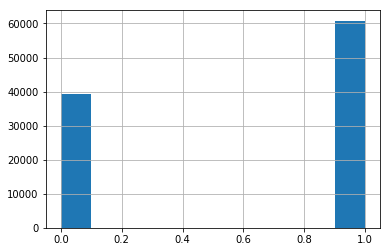

In [21]:
train.head(100000).NewEstimateTotal.hist()

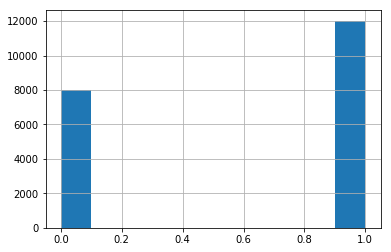

In [22]:
valid.head(20000).NewEstimateTotal.hist()

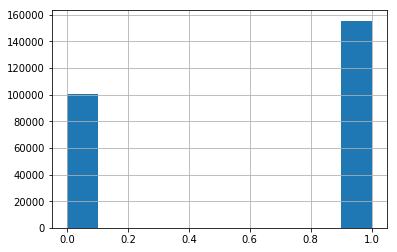

In [23]:
test.NewEstimateTotal.hist()